# CIFAR-10 Image Classification with PyTorch

## Introduction

This project demonstrates the process of image classification using the CIFAR-10 dataset with PyTorch. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The classes in the dataset include objects like airplanes, cars, birds, cats, and more.

In this project, we will:
1. Load and preprocess the CIFAR-10 dataset.
2. Define a simple convolutional neural network (CNN) model.
3. Train the model on the training data.
4. Evaluate the model's performance on the test set.

The dataset is provided in a compressed format (7z), with labels stored in a separate CSV file. The images are extracted from the 7z archive and loaded using custom data handling techniques to match the labels with the corresponding images.

## Requirements

- PyTorch
- torchvision
- pandas
- matplotlib
- PIL


In [25]:
import os
from PIL import Image
import sys
import time


import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Check if GPU is available and move model and data accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set random seed for reproducibility
seed = 42  # You can use any number for the seed

# Set the seed for various libraries
torch.manual_seed(seed)  # Set the seed for CPU
torch.cuda.manual_seed(seed)  # Set the seed for GPU
torch.cuda.manual_seed_all(seed)  # For all GPUs (if you're using more than one GPU)
np.random.seed(seed)  # Set the seed for numpy
random.seed(seed)  # Set the seed for Python random library

# Ensuring deterministic behavior in CUDA (optional, but helps in reproducibility)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


### Showing Classes in Dataset

This Python script shows the class names in the `train` directory.

In [26]:
sz = 224 
num_epochs = 50
batch_size = 32 
train_dir = 'dataset/train_data'
valid_dir = 'dataset/valid_data'
classes_name = os.listdir(train_dir)
num_classes = len(classes_name)
print(classes_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Displaying Images from the Dataset

In this section, a specified number of images from each class in the dataset are randomly selected and displayed in a grid format.

The code below selects 5 images from each class in the dataset and displays them in a grid:


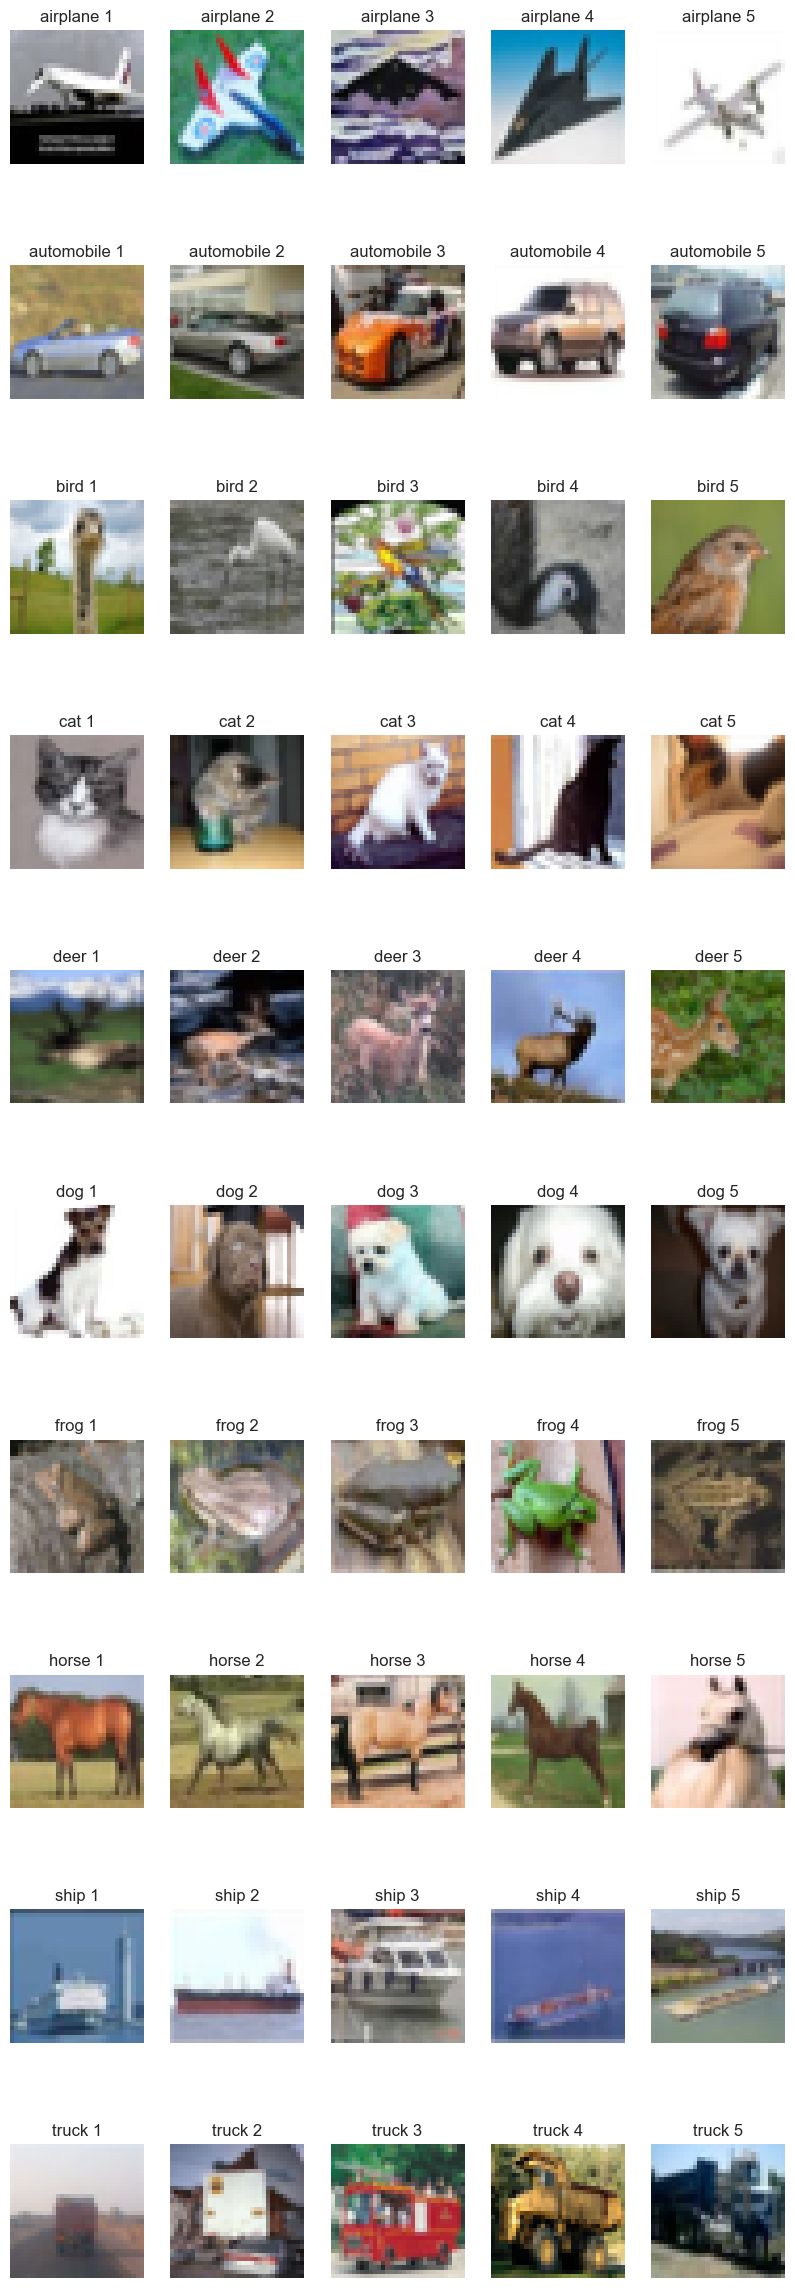

In [28]:
def grid_show_imgs(train_dir, classes_name, num_img_show =5):
    fig, axs = plt.subplots(len(classes_name), num_img_show, figsize=(10, len(classes_name) * 3))
    for i, class_name in enumerate(classes_name):
        class_name_dir = os.path.join(train_dir, class_name)
        images_list = [f for f in os.listdir(class_name_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
        images_list_random = random.sample(images_list, num_img_show)
        for j, image in enumerate(images_list_random):
            image_dir = os.path.join(class_name_dir, image)
            img = Image.open(image_dir)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{class_name} {j + 1}')
num_img_show = 5
grid_show_imgs(train_dir, classes_name, num_img_show)

### Counting Class Samples in a Dataset Directory

The following function is designed to count the number of samples for each class in a dataset directory. This is particularly useful for inspecting the distribution of data across different classes, which can help identify imbalances in the dataset.

In [29]:
def count_class_samples(data_dir):
    """
    Counts the number of samples for each class in a dataset directory.

    Args:
        data_dir (str): Path to the dataset directory. Each subdirectory represents a class.

    Returns:
        dict: A dictionary with class names as keys and number of samples as values.
    """
    class_counts = {}
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):  # Check if it's a directory
            class_counts[folder] = len(os.listdir(folder_path))  # Count files in the directory
    return class_counts

train_counts = count_class_samples(train_dir)
valid_counts = count_class_samples(valid_dir)

print("Train Class Counts:", train_counts)
print("\nValid Class Counts:", valid_counts)

Train Class Counts: {'airplane': 4282, 'automobile': 4268, 'bird': 4248, 'cat': 4252, 'deer': 4238, 'dog': 4235, 'frog': 4217, 'horse': 4204, 'ship': 4201, 'truck': 4192}

Valid Class Counts: {'airplane': 718, 'automobile': 732, 'bird': 752, 'cat': 748, 'deer': 762, 'dog': 765, 'frog': 783, 'horse': 796, 'ship': 799, 'truck': 808}


# Data Preparation and Loading

This code prepares image data for a deep learning model by applying necessary preprocessing steps and creating data loaders for training and validation datasets.

---

### Steps:
1. **Data Transformation**:
   - Images are resized, converted to tensors, and normalized based on standard ImageNet statistics.

2. **Dataset Creation**:
   - Training and validation datasets are created using the directory structure, with labels inferred automatically from folder names.

3. **Data Loading**:
   - Data loaders are initialized for both datasets to handle batching, shuffling (for training), and parallel processing for efficiency.

4. **Dataset Size Display**:
   - The total number of samples in each dataset is printed to ensure proper loading.


In [30]:
transform = transforms.Compose([
    transforms.Resize((sz, sz)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Create custom CIFAR-10 datasets for training and validation
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)

# Create data loaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)

# Print the number of samples in each dataset
print("Training data:", len(train_loader.dataset))
print("Validation data:", len(valid_loader.dataset))


Training data: 42337
Validation data: 7663


### Visualizing Class Distribution in the Training Dataset

This code snippet generates a bar chart to display the class distribution in the training dataset, helping to identify any imbalance in the dataset. Below are the steps and details about the implementation:

#### Purpose:

This visualization helps to:
- Identify whether the dataset is balanced across all classes.
- Highlight any significant discrepancies in class counts, which may require handling during model training (e.g., oversampling, undersampling, or class weighting).

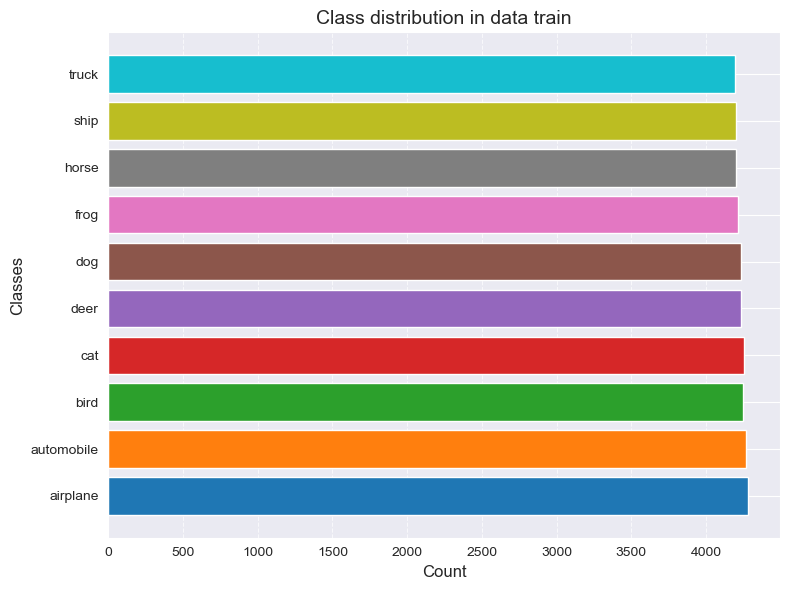

In [31]:
# Extracting keys (class names) and values (counts) from the dictionary
classes = list(train_counts.keys())
counts = list(train_counts.values())

# Generating a unique color for each class
colors = [plt.cm.tab20(i / len(classes)) for i in range(len(classes))]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 6))  # Set the figure size
plt.barh(classes, counts, color=colors)  # Create a horizontal bar chart with different colors

# Adding labels, title, and customizing the plot
plt.xlabel('Count', fontsize=12)  # Label for the x-axis (horizontal axis)
plt.ylabel('Classes', fontsize=12)  # Label for the y-axis (vertical axis)
plt.title('Class distribution in data train', fontsize=14)  # Title of the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines on the x-axis

# Adjust layout to ensure labels fit well
plt.tight_layout()

# Display the plot
plt.show()


### Model Initialization and Transfer Learning

In this section, we initialize a pre-trained **ResNet101** model using **Transfer Learning**. Transfer Learning allows us to leverage a model that has been trained on a large dataset (like ImageNet) and fine-tune it for our specific task, which significantly reduces the training time and can lead to better performance, especially with limited data.

In [42]:
def load_pretrained_resnet101(model_path=None, num_classes=10):
    use_gpu = torch.cuda.is_available() 
    if model_path is None:
        model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
       # for param in model.parameters():
           # param.require_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.load_state_dict(torch.load(model_path))
    
    if use_gpu:
        model = model.cuda()
        
    return model

model = load_pretrained_resnet101(model_path=None, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss Function and Optimizer Setup

In this section, we define the **loss function** and the **optimizer** for training the model. These components are crucial for guiding the model's learning process during training.

In [43]:
criterion = nn.CrossEntropyLoss() # Define the loss function (Cross-Entropy Loss) 
optimizer = optim.Adam(model.fc.parameters(), lr=0.1) # Define the optimizer (Adam optimizer) for fine-tuning the fully connected layer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # Decreases the learning rate by a factor of gamma every 

### Training Pipeline with Early Stopping and Loss Monitoring

This script provides a structured training framework in PyTorch, including early stopping, loss tracking, and learning rate scheduling.

---


#### **1. EarlyStopping Class**
- Stops training if validation accuracy doesn't improve for `patience` epochs.
- Saves the best model weights (`best_model_wts`).

---

#### **2. Training One Epoch**
- Trains the model for one epoch, tracks loss and accuracy, and updates weights.
- Reports batch-wise progress.

---

#### **3. Model Validation**
- Evaluates the model on validation data, calculating loss and accuracy.
- Tracks validation loss for early stopping.

---

#### **4. Training Loop**
- Orchestrates training and validation across epochs.
- Features:
  - Learning rate scheduling.
  - Early stopping to avoid overfitting.
  - Automatic saving of the best model.
  - Records training/validation losses for analysis.

In [44]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        """
        Initialize EarlyStopping.

        Args:
            patience (int): Number of epochs with no improvement to wait before stopping.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience  # Number of epochs to wait for improvement
        self.delta = delta  # Minimum change to qualify as an improvement
        self.counter = 0  # Counter for epochs with no improvement
        self.best_score = None  # Best validation score
        self.early_stop = False  # Flag to stop training
        self.best_model_wts = None  # Best model weights

    def __call__(self, val_score, model):
        """
        Check if early stopping should be triggered.

        Args:
            val_score (float): The validation score (e.g., accuracy or loss).
            model (torch.nn.Module): The model to save the best weights.
        """
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if no improvement
        else:
            self.best_score = val_score
            self.counter = 0
            self.best_model_wts = model.state_dict().copy()  # Save the best model weights

def train_one_epoch(model, dataloader, criterion, optimizer, device, train_losses):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader for training data.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device to run the model on.
        train_losses (list): List to store training losses.

    Returns:
        model (torch.nn.Module): The trained model.
    """
    model.train()

    steps = len(dataloader.dataset) // dataloader.batch_size

    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

        # Statistics
        running_loss = (running_loss * i + loss.item()) / (i + 1)
        running_corrects += torch.sum(outputs.argmax(1) == labels)

        # Report progress
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f" % (i, steps, loss.item()))

    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloader.dataset)

    # Add the loss to the train_losses list
    train_losses.append(epoch_loss)

    sys.stdout.flush()
    print('\r{} Loss: {:.5f} Acc: {:.5f}'.format('  train', epoch_loss, epoch_acc))

    return model

def validate_model(model, dataloader, criterion, device, valid_losses):
    """
    Validate the model after training.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The data loader for validation data.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device to run the model on.
        valid_losses (list): List to store validation losses.

    Returns:
        epoch_acc (float): The validation accuracy for the current epoch.
    """
    model.eval()

    steps = len(dataloader.dataset) // dataloader.batch_size

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss = (running_loss * i + loss.item()) / (i + 1)
            running_corrects += torch.sum(outputs.argmax(1) == labels)

            # Report progress
            sys.stdout.flush()
            sys.stdout.write("\r  Step %d/%d | Loss: %.5f" % (i, steps, loss.item()))

    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloader.dataset)

    # Add the loss to the valid_losses list
    valid_losses.append(epoch_loss)

    sys.stdout.flush()
    print('\r{} Loss: {:.5f} Acc: {:.5f}'.format('  valid', epoch_loss, epoch_acc))

    return epoch_acc

def train_model(model, train_dl, valid_dl, criterion, optimizer, device,
                scheduler=None, num_epochs=10, patience=5):
    """
    Train the model over multiple epochs and validate it.

    Args:
        model (torch.nn.Module): The model to train.
        train_dl (torch.utils.data.DataLoader): Data loader for training data.
        valid_dl (torch.utils.data.DataLoader): Data loader for validation data.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device to run the model on.
        scheduler (torch.optim.lr_scheduler, optional): The learning rate scheduler.
        num_epochs (int): Number of epochs to train the model.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        model (torch.nn.Module): The trained model.
        train_losses (list): List of training losses for each epoch.
        valid_losses (list): List of validation losses for each epoch.
    """
    if not os.path.exists('models'):
        os.mkdir('models')

    device = device or torch.device('cpu')

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    num_epoch_save = 10

    # Create lists to store losses
    train_losses = []
    valid_losses = []

    early_stopping = EarlyStopping(patience=patience, delta=0)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Train and validate the model
        model = train_one_epoch(model, train_dl, criterion, optimizer, device, train_losses)
        val_acc = validate_model(model, valid_dl, criterion, device, valid_losses)

        if scheduler is not None:
            scheduler.step()

        # Check for early stopping
        early_stopping(val_acc, model)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Deep copy the model if it improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, "./models/epoch-{}-acc-{:.5f}.pth".format(epoch, best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the lists of losses for later plotting
    return model, train_losses, valid_losses


In [47]:
'''model, train_losses, valid_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, device, scheduler, num_epochs=num_epochs)'''
print('accuracy for validation = 0.83127')

accuracy for validation = 0.83127


### Confusion Matrix

A **confusion matrix** is a performance measurement tool for machine learning classification tasks. It helps to understand how well a model is performing by comparing the predicted labels with the actual labels. The matrix contains counts of actual versus predicted classifications, allowing us to analyze which classes are correctly or incorrectly classified.

C:\Users\Sepehr\AppData\Local\Temp\ipykernel_3320\52983637.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


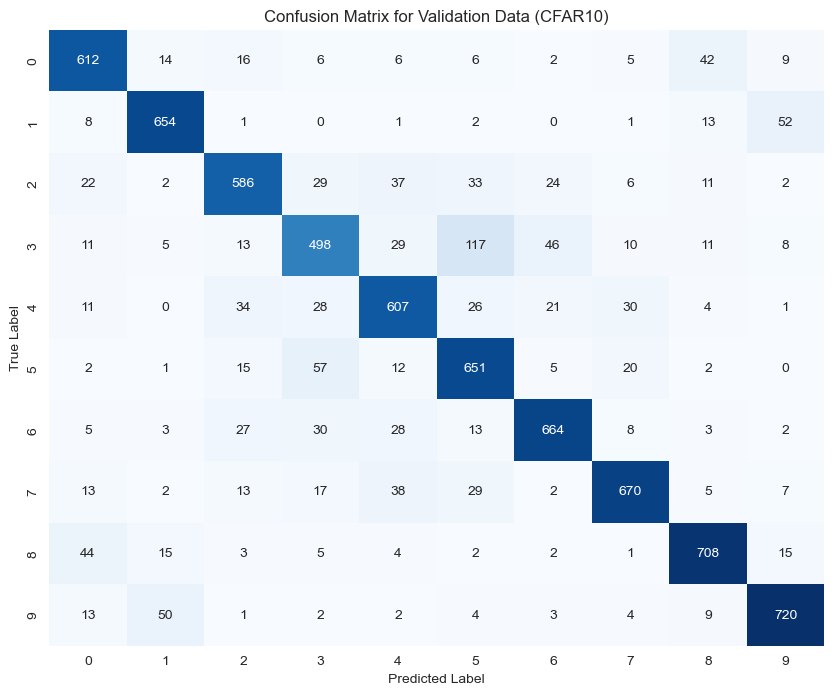

In [45]:
model = load_pretrained_resnet101(model_path='models/epoch-10-acc-0.83127.pth', num_classes=num_classes)
model.to(device) 
model.eval()

# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in valid_loader:
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class (index with max probability)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix for Validation Data (CFAR10)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
